In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/

/content/drive


In [ ]:
cd MyDrive/

/content/drive/MyDrive


In [ ]:
cd speech_to_text/

/content/drive/MyDrive/speech_to_text


In [ ]:
ls

speech_to_text.ipynb


In [ ]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [ ]:
data_url = "http://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)

In [ ]:
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

In [ ]:
#read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)

In [ ]:
metadata_df.head(10)

,file_name,normalized_transcription
0,LJ005-0120,Half the jails had no code of rules properly p...
1,LJ001-0033,but which must certainly have come from the st...
2,LJ043-0164,and his role would have been made clear by the...
3,LJ011-0280,Mr. Gee at first stoutly refused.
4,LJ005-0262,it was suggested that the rules framed for pri...
5,LJ006-0124,"the prisoner official already mentioned, who h..."
6,LJ028-0152,In the circuit of the wall are a hundred gates...
7,LJ046-0177,which is maintained on a geographical field of...
8,LJ043-0171,I am guessing that perhaps he did it to appear...
9,LJ012-0129,learnt through the firm's correspondence that ...


In [ ]:
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

In [ ]:
#split
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of training set: {len(df_train)}")
print(f"Size of training set: {len(df_val)}")

Size of training set: 11790
Size of training set: 1310


In [ ]:
#The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
#Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
#Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}"
    f"(size = {char_to_num.vocabulary_size()})" 
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '](size = 31)


In [ ]:
char_to_num

In [ ]:
frame_length = 256
frame_step = 160
fft_length = 384

def encode_single_sample(wav_file, label):
  # 1. Read wav file
  file = tf.io.read_file(wavs_path + wav_file + ".wav")

  # 2. Decode wav file
  audio, _ = tf.audio.decode_wav(file)
  audio = tf.squeeze(audio, axis=-1)

  # 3. Change type to float
  audio = tf.cast(audio, tf.float32)

  # 4. Get the spectrogram
  spectrogram = tf.signal.stft(
      audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
  )

  # 5. We only need the magnitude, which can be derived by aplying tf.abs
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.math.pow(spectrogram, 0.5)

  # 6. Normalisation
  means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
  stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
  spectrogram = (spectrogram - means) / (stddevs + 1e-10)

  ##
  ## Process the label
  ##

  # 7. Convert label to lowercase
  label = tf.strings.lower(label)

  # 8. Split the label
  label = tf.strings.unicode_split(label, input_encoding="UTF-8")

  # 9. Map the characters in label to numbers
  label = char_to_num(label)

  #10. Return a dict as our model is expecting two inputs
  return spectrogram, label

In [ ]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

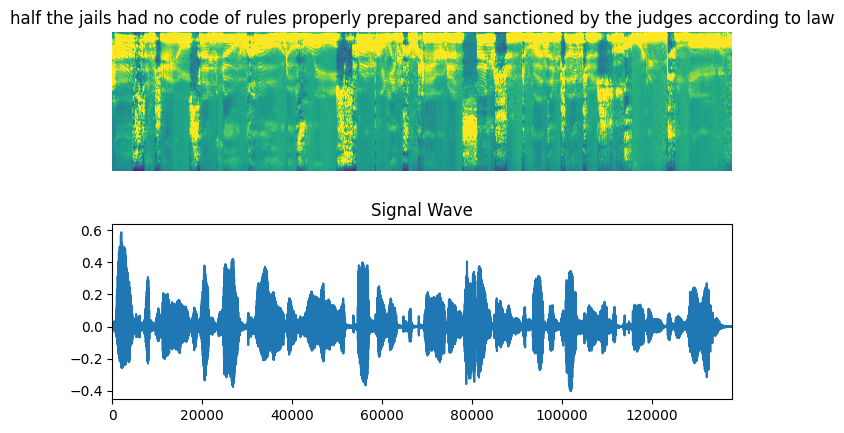

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
  spectrogram = batch[0][0].numpy()
  spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
  label = batch[1][0]

  label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
  ax = plt.subplot(2, 1, 1)
  ax.imshow(spectrogram, vmax=1)
  ax.set_title(label)
  ax.axis("off")

  file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
  audio, _ = tf.audio.decode_wav(file)
  audio = audio.numpy()
  ax = plt.subplot(2, 1, 2)
  plt.plot(audio)
  ax.set_title("Signal Wave")
  ax.set_xlim(0, len(audio))
  display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [ ]:
# Model
def CTCLoss(y_true, y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
  input_lenght = tf.cast(tf.shape(y_pred)[1], dtype="int64")
  label_lenght = tf.cast(tf.shape(y_true)[1], dtype="int64")

  input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
  # Model's input
  input_spectrogram = layers.Input((None, input_dim), name="input")

  # Expand the dimension to use 2D CNN
  x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)

  # Convolution layer 1
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 41],
      strides=[2, 2]
      padding="same",
      use_bias=False,
      name="conv_1",
  )(x)
  x = layers.BatchNormalization(name="conv_1_bn")(x)
  x = layers.ReLU(name="conv_1_relu")(x)

  # Convolution layer 2
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 21],
      strides=[1, 2]
      padding="same",
      use_bias=False,
      name="conv_2",
  )(x)
  x = layers.BatchNormalization(name="conv_2_bn")(x)
  x = layers.ReLU(name="conv_2_relu")(x)

  # Reshape the resulted volume to feed the RNNs layers
  x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

  # RNN layers
  for i in range(1, rnn_layers + 1):
    recurrent = layers.GRU(
        units=rnn_units,
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        return_sequences=True,
        reset_after=True,
        name=f"gru_{i}"
    )
    x = layers.Bidirectional(
        recurrent, name=f"bidirectional_{i}", merge_mode="concat"
    )(x)
    if i < rnn_layers:
      x = layers.Dropout(rate=0.5)(x)

    